# exp009 地価公示特徴量 - 分析レポート

## 実験概要
- **実験ID**: exp009_landprice
- **ベース**: exp008_reform_features (CV MAPE: 13.44%)
- **追加特徴量**: 地価公示データ (39次元)
- **結果**: CV MAPE 12.67% (約0.78pt改善)

## 1. セットアップ

In [1]:
import sys
from pathlib import Path

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# パス設定
exp_dir = Path.cwd().parent
output_dir = exp_dir / "outputs"

# 日本語フォント設定
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['axes.unicode_minus'] = False

print(f"実験ディレクトリ: {exp_dir}")
print(f"出力ディレクトリ: {output_dir}")

実験ディレクトリ: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp009_landprice
出力ディレクトリ: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp009_landprice/outputs


## 2. 特徴量重要度分析

In [2]:
# 特徴量重要度の読み込み
importance_files = list(output_dir.glob("feature_importance_*.csv"))
latest_file = sorted(importance_files)[-1]
importance_df = pl.read_csv(latest_file)
print(f"読み込みファイル: {latest_file.name}")
print(f"総特徴量数: {len(importance_df)}")
importance_df.head(10)

読み込みファイル: feature_importance_20251127_091113.csv
総特徴量数: 220


feature,importance
str,f64
"""lp_ratio_3to5""",39752.666667
"""lp_change_rate""",36164.333333
"""lp_ratio_1to3""",34955.666667
"""post_full_lp_ratio""",29943.333333
"""super_distance""",25550.0
"""house_area_pref_ratio""",24776.666667
"""post2""",24499.0
"""lp_nearest_dist""",23597.666667
"""unit_tag_svd_0""",23566.0


In [3]:
# カテゴリ分類関数
def categorize_feature(name: str) -> str:
    if name.startswith("lp_") or "_lp_" in name:
        return "地価公示 (exp009 NEW)"
    elif "unit_tag_svd" in name:
        return "ユニットタグSVD (exp007)"
    elif "building_tag_svd" in name:
        return "建物タグSVD (exp007)"
    elif "reform" in name:
        return "リフォーム (exp008)"
    elif "_te" in name:
        return "Target Encoding"
    elif "_count" in name:
        return "Count Encoding"
    elif "_le" in name:
        return "Label Encoding"
    elif any(x in name for x in ["distance", "walk_time", "access_time", "eki_", "rosen_"]):
        return "アクセス関連"
    elif any(x in name for x in ["area", "menseki"]):
        return "面積関連"
    elif any(x in name for x in ["geo_", "lat", "lon"]):
        return "地理関連"
    else:
        return "その他"

# カテゴリ列追加
importance_df = importance_df.with_columns(
    pl.col("feature").map_elements(categorize_feature, return_dtype=pl.Utf8).alias("category")
)

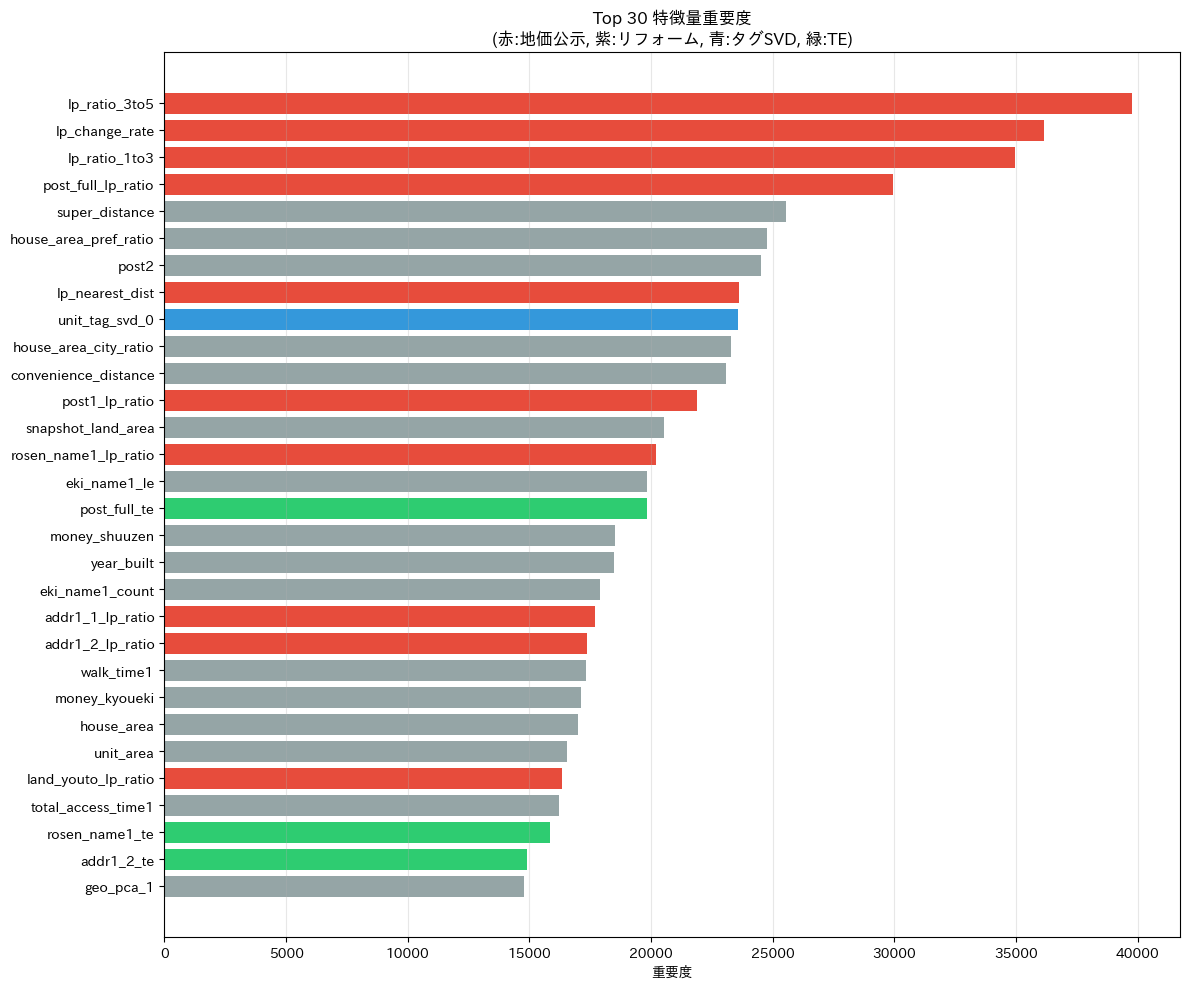

In [4]:
# Top30特徴量の可視化
top_n = 30
top_features = importance_df.head(top_n)

# 色分け
colors = []
for cat in top_features["category"].to_list():
    if "地価" in cat:
        colors.append("#E74C3C")  # 赤
    elif "タグSVD" in cat:
        colors.append("#3498DB")  # 青
    elif "Target" in cat:
        colors.append("#2ECC71")  # 緑
    elif "リフォーム" in cat:
        colors.append("#9B59B6")  # 紫
    else:
        colors.append("#95A5A6")  # グレー

fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(top_n)

ax.barh(y_pos, top_features["importance"].to_numpy()[::-1], color=colors[::-1])
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features["feature"].to_list()[::-1])
ax.set_xlabel("重要度")
ax.set_title(f"Top {top_n} 特徴量重要度\n(赤:地価公示, 紫:リフォーム, 青:タグSVD, 緑:TE)")
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "top30_importance.png", dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# カテゴリ別重要度集計
category_stats = importance_df.to_pandas().groupby("category")["importance"].agg(["sum", "mean", "count"])
category_stats = category_stats.sort_values("sum", ascending=False)
print("=== カテゴリ別重要度 ===")
display(category_stats)

=== カテゴリ別重要度 ===


,sum,mean,count
category,,,
地価公示 (exp009 NEW),459822.333333,11790.316239,39
ユニットタグSVD (exp007),415811.333333,13860.377778,30
その他,231984.666667,3682.296296,63
アクセス関連,169456.000000,14121.333333,12
面積関連,144585.000000,11121.923077,13
建物タグSVD (exp007),141472.000000,9431.466667,15
Target Encoding,108028.000000,12003.111111,9
Count Encoding,105171.333333,4382.138889,24
Label Encoding,56113.000000,14028.250000,4


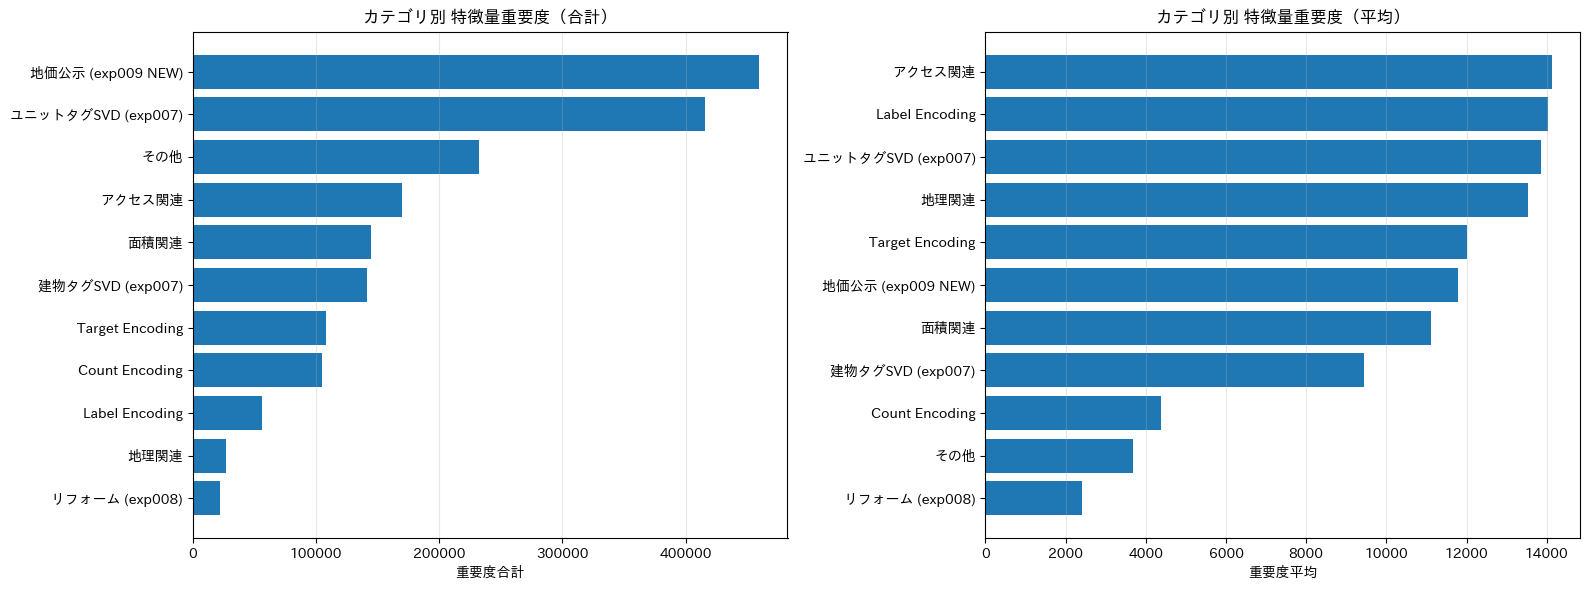

In [6]:
# カテゴリ別重要度の可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 合計
ax = axes[0]
y_pos = np.arange(len(category_stats))
ax.barh(y_pos, category_stats["sum"].values[::-1])
ax.set_yticks(y_pos)
ax.set_yticklabels(category_stats.index.tolist()[::-1])
ax.set_xlabel("重要度合計")
ax.set_title("カテゴリ別 特徴量重要度（合計）")
ax.grid(axis='x', alpha=0.3)

# 平均
ax = axes[1]
category_stats_by_mean = category_stats.sort_values("mean", ascending=False)
ax.barh(y_pos, category_stats_by_mean["mean"].values[::-1])
ax.set_yticks(y_pos)
ax.set_yticklabels(category_stats_by_mean.index.tolist()[::-1])
ax.set_xlabel("重要度平均")
ax.set_title("カテゴリ別 特徴量重要度（平均）")
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "category_importance.png", dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# 地価公示特徴量の重要度
lp_features = importance_df.filter(
    pl.col("category").str.contains("地価")
).sort("importance", descending=True)

print(f"地価公示特徴量数: {len(lp_features)}")
print(f"重要度合計: {lp_features['importance'].sum():,.0f}")
print(f"全体に占める割合: {lp_features['importance'].sum() / importance_df['importance'].sum() * 100:.1f}%")
print("\n=== 地価公示特徴量ランキング ===")
lp_features

地価公示特徴量数: 39
重要度合計: 459,822
全体に占める割合: 24.4%

=== 地価公示特徴量ランキング ===


feature,importance,category
str,f64,str
"""lp_ratio_3to5""",39752.666667,"""地価公示 (exp009 NEW)"""
"""lp_change_rate""",36164.333333,"""地価公示 (exp009 NEW)"""
"""lp_ratio_1to3""",34955.666667,"""地価公示 (exp009 NEW)"""
"""post_full_lp_ratio""",29943.333333,"""地価公示 (exp009 NEW)"""
"""lp_nearest_dist""",23597.666667,"""地価公示 (exp009 NEW)"""
…,…,…
"""addr1_1_lp_mean""",3390.0,"""地価公示 (exp009 NEW)"""
"""land_youto_lp_mean""",2681.333333,"""地価公示 (exp009 NEW)"""
"""land_toshi_lp_mean""",183.0,"""地価公示 (exp009 NEW)"""


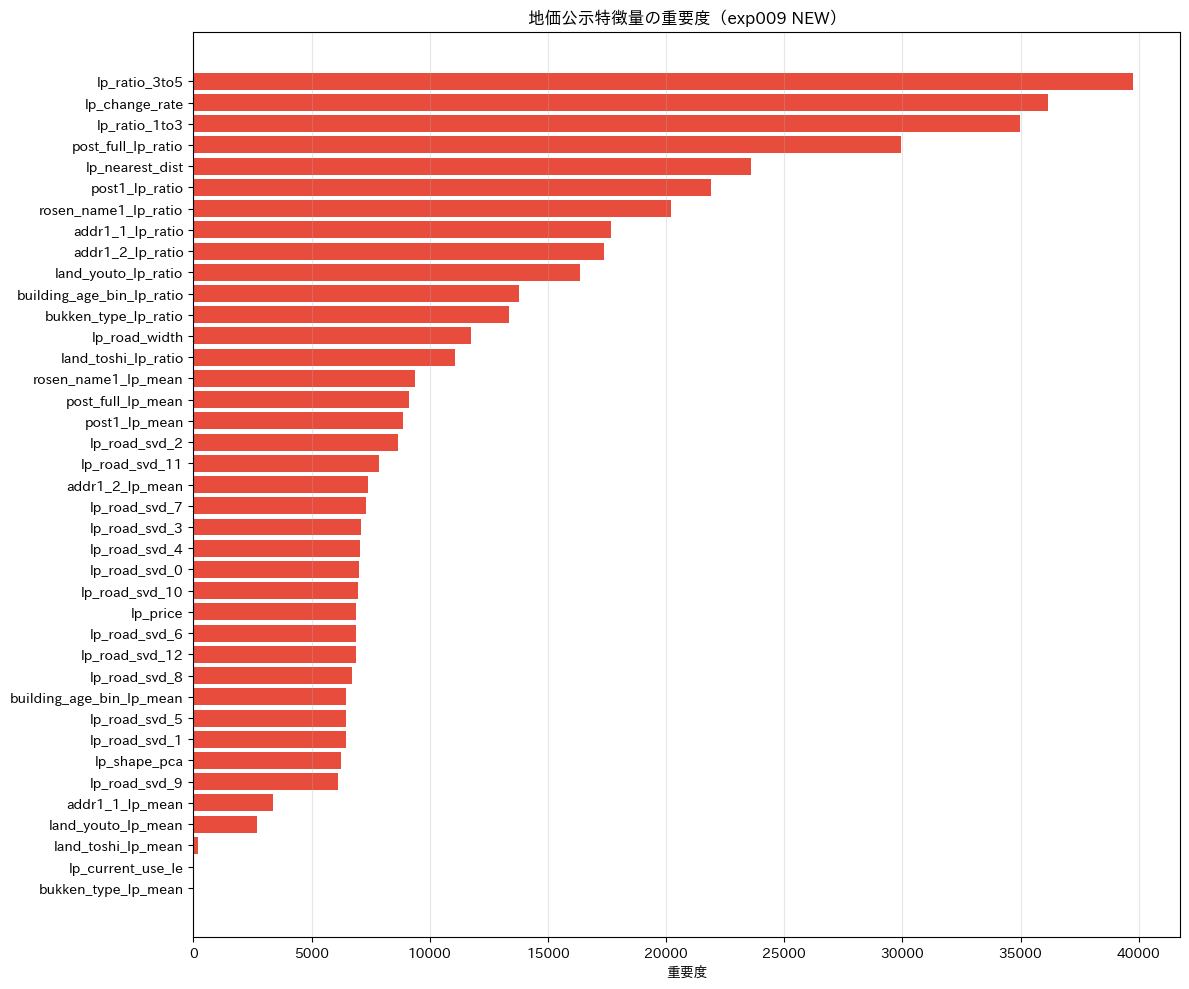

In [8]:
# 地価公示特徴量の可視化
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(lp_features))

ax.barh(y_pos, lp_features["importance"].to_numpy()[::-1], color='#E74C3C')
ax.set_yticks(y_pos)
ax.set_yticklabels(lp_features["feature"].to_list()[::-1])
ax.set_xlabel("重要度")
ax.set_title("地価公示特徴量の重要度（exp009 NEW）")
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "landprice_importance.png", dpi=150, bbox_inches='tight')
plt.show()

## 3. エラー分析

In [9]:
# OOF予測の読み込み
oof_files = list(output_dir.glob("oof_predictions_*.csv"))
latest_oof = sorted(oof_files)[-1]
oof_df = pl.read_csv(latest_oof)
print(f"読み込みファイル: {latest_oof.name}")
print(f"OOF予測数: {len(oof_df)}")
oof_df.head()

読み込みファイル: oof_predictions_20251127_091113.csv
OOF予測数: 363924


id,actual,predicted
i64,i64,f64
0,13980000,1.6245e7
1,24480000,2.4807e7
2,24480000,2.3030e7
3,16300000,2.0762e7
4,18800000,1.7688e7


In [10]:
# エラー計算
oof_df = oof_df.with_columns([
    (pl.col("predicted") - pl.col("actual")).alias("error"),
    ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
])

print("=== エラー統計 ===")
print(f"MAPE: {oof_df['ape'].mean():.2f}%")
print(f"Median APE: {oof_df['ape'].median():.2f}%")
print(f"MAE: {oof_df['error'].abs().mean():,.0f}円")
print(f"RMSE: {np.sqrt((oof_df['error'] ** 2).mean()):,.0f}円")

=== エラー統計 ===
MAPE: 12.48%
Median APE: 8.32%
MAE: 2,904,479円
RMSE: 5,071,557円


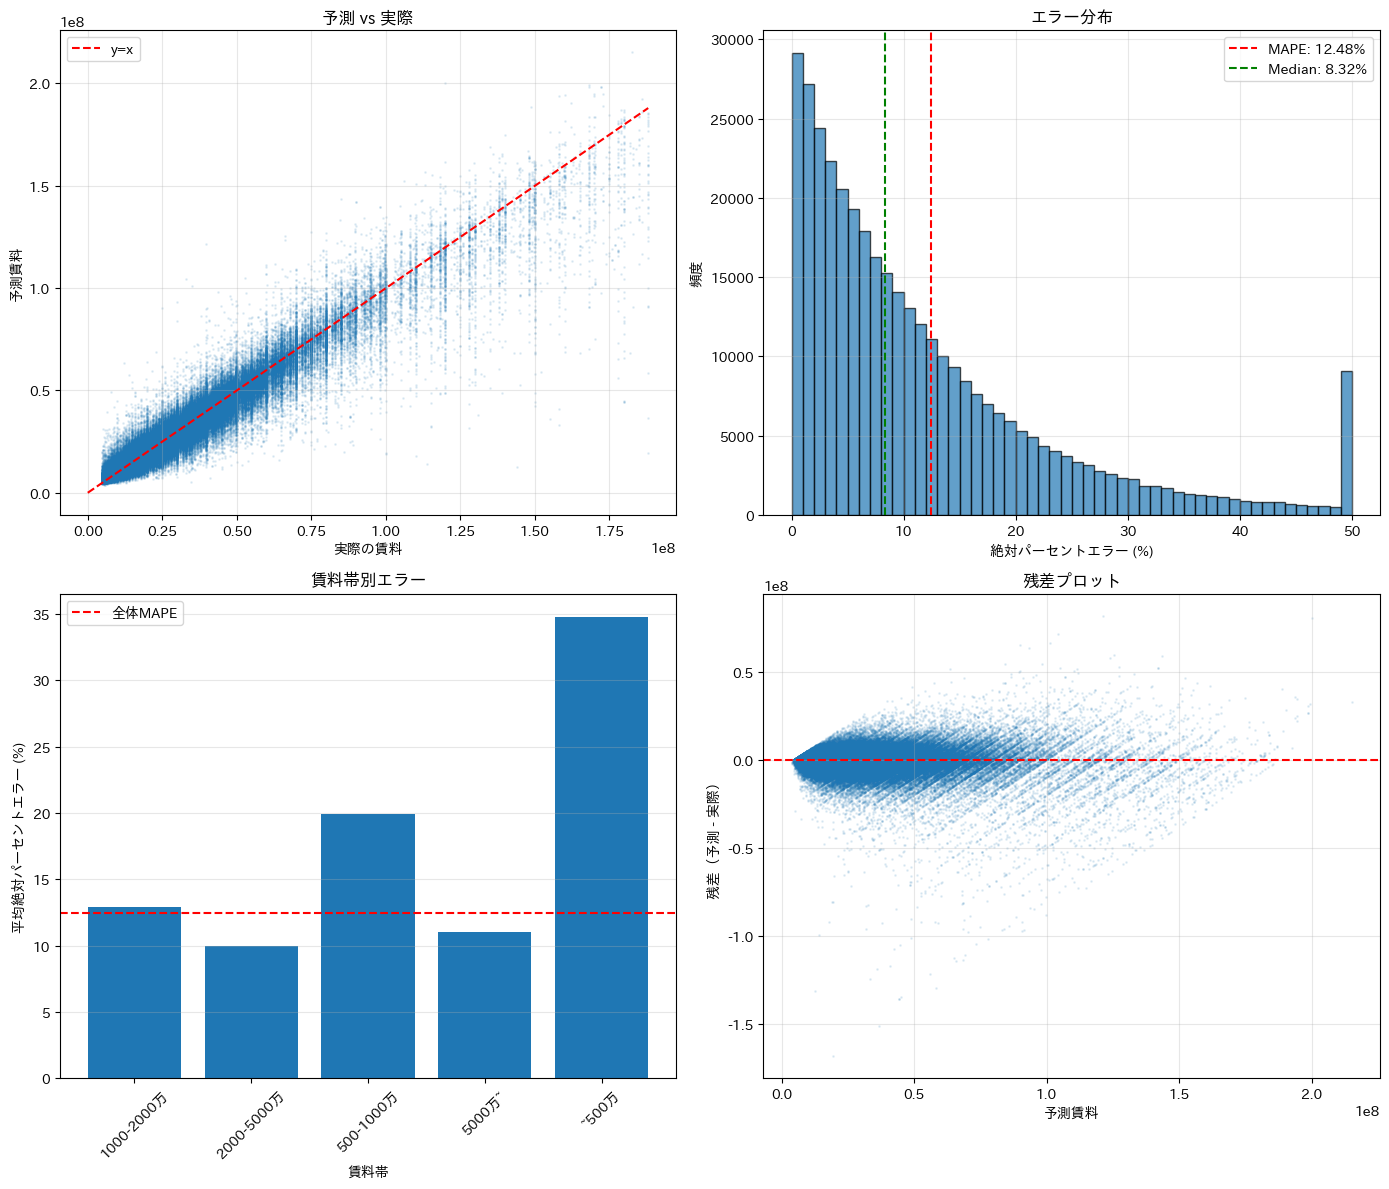

In [11]:
# エラー分析の可視化（4パネル）
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

actual = oof_df["actual"].to_numpy()
predicted = oof_df["predicted"].to_numpy()
ape = oof_df["ape"].to_numpy()
error = oof_df["error"].to_numpy()

# 1. 予測 vs 実際
ax = axes[0, 0]
ax.scatter(actual, predicted, alpha=0.1, s=1)
ax.plot([0, actual.max()], [0, actual.max()], 'r--', label='y=x')
ax.set_xlabel("実際の賃料")
ax.set_ylabel("予測賃料")
ax.set_title("予測 vs 実際")
ax.legend()
ax.grid(alpha=0.3)

# 2. APE分布
ax = axes[0, 1]
ape_clipped = np.clip(ape, 0, 50)
ax.hist(ape_clipped, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(ape.mean(), color='red', linestyle='--', label=f'MAPE: {ape.mean():.2f}%')
ax.axvline(np.median(ape), color='green', linestyle='--', label=f'Median: {np.median(ape):.2f}%')
ax.set_xlabel("絶対パーセントエラー (%)")
ax.set_ylabel("頻度")
ax.set_title("エラー分布")
ax.legend()
ax.grid(alpha=0.3)

# 3. 賃料帯別エラー
ax = axes[1, 0]
price_bins = [5_000_000, 10_000_000, 20_000_000, 50_000_000]
price_labels = ['~500万', '500-1000万', '1000-2000万', '2000-5000万', '5000万~']
oof_df = oof_df.with_columns([
    pl.col("actual").cut(price_bins, labels=price_labels).alias("price_bin")
])

price_bin_stats = oof_df.group_by("price_bin").agg([
    pl.col("ape").mean().alias("mape"),
]).sort("price_bin")

x = np.arange(len(price_bin_stats))
ax.bar(x, price_bin_stats["mape"].to_numpy())
ax.axhline(ape.mean(), color='red', linestyle='--', label='全体MAPE')
ax.set_xticks(x)
ax.set_xticklabels(price_bin_stats["price_bin"].to_list(), rotation=45)
ax.set_xlabel("賃料帯")
ax.set_ylabel("平均絶対パーセントエラー (%)")
ax.set_title("賃料帯別エラー")
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 4. 残差プロット
ax = axes[1, 1]
ax.scatter(predicted, error, alpha=0.1, s=1)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("予測賃料")
ax.set_ylabel("残差（予測 - 実際）")
ax.set_title("残差プロット")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "error_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# 賃料帯別の詳細統計
price_bin_detail = oof_df.group_by("price_bin").agg([
    pl.len().alias("件数"),
    pl.col("actual").mean().alias("平均賃料"),
    pl.col("ape").mean().alias("MAPE"),
    pl.col("ape").median().alias("Median APE"),
    pl.col("ape").std().alias("APE Std"),
    pl.col("error").abs().mean().alias("MAE"),
]).sort("price_bin")

print("=== 賃料帯別の詳細統計 ===")
price_bin_detail

=== 賃料帯別の詳細統計 ===


price_bin,件数,平均賃料,MAPE,Median APE,APE Std,MAE
cat,u32,f64,f64,f64,f64,f64
"""1000-2000万""",120082,1.5535e7,12.925753,9.107808,13.736838,1.9811e6
"""2000-5000万""",168548,3.1079e7,9.973254,7.340737,9.657391,3.0749e6
"""500-1000万""",46734,7.9223e6,19.932976,11.506592,25.68236,1.5382e6
"""5000万~""",25987,7.4962e7,11.051505,7.9766,10.739992,8.6395e6
"""~500万""",2573,4.9626e6,34.782401,22.210143,42.900192,1.7268e6


## 4. exp008 vs exp009 比較

In [13]:
# exp008のOOF予測読み込み
exp008_dir = exp_dir.parent / "exp008_reform_features" / "outputs"
exp008_oof_files = list(exp008_dir.glob("oof_predictions_*.csv"))

if exp008_oof_files:
    exp008_oof = pl.read_csv(sorted(exp008_oof_files)[-1])
    exp008_oof = exp008_oof.with_columns([
        ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
        pl.col("actual").cut(price_bins, labels=price_labels).alias("price_bin")
    ])
    
    exp008_mape = exp008_oof["ape"].mean()
    exp009_mape = oof_df["ape"].mean()
    
    print("=== exp008 vs exp009 比較 ===")
    print(f"exp008 MAPE: {exp008_mape:.2f}%")
    print(f"exp009 MAPE: {exp009_mape:.2f}%")
    print(f"改善: {exp008_mape - exp009_mape:.2f}pt ({(exp008_mape - exp009_mape) / exp008_mape * 100:.1f}%)")
else:
    print("exp008のOOF予測が見つかりません")
    exp008_oof = None

=== exp008 vs exp009 比較 ===
exp008 MAPE: 13.44%
exp009 MAPE: 12.48%
改善: 0.96pt (7.2%)


In [14]:
# 賃料帯別比較
if exp008_oof is not None:
    exp008_by_bin = exp008_oof.group_by("price_bin").agg(
        pl.col("ape").mean().alias("exp008")
    ).sort("price_bin")
    
    exp009_by_bin = oof_df.group_by("price_bin").agg(
        pl.col("ape").mean().alias("exp009")
    ).sort("price_bin")
    
    comparison = exp008_by_bin.join(exp009_by_bin, on="price_bin")
    comparison = comparison.with_columns(
        (pl.col("exp008") - pl.col("exp009")).alias("改善(pt)")
    )
    
    print("=== 賃料帯別 MAPE比較 ===")
    display(comparison.to_pandas().set_index("price_bin").round(2))

=== 賃料帯別 MAPE比較 ===


,exp008,exp009,改善(pt)
price_bin,,,
1000-2000万,13.66,12.93,0.73
2000-5000万,10.88,9.97,0.90
500-1000万,21.43,19.93,1.50
5000万~,12.35,11.05,1.29
~500万,37.35,34.78,2.57


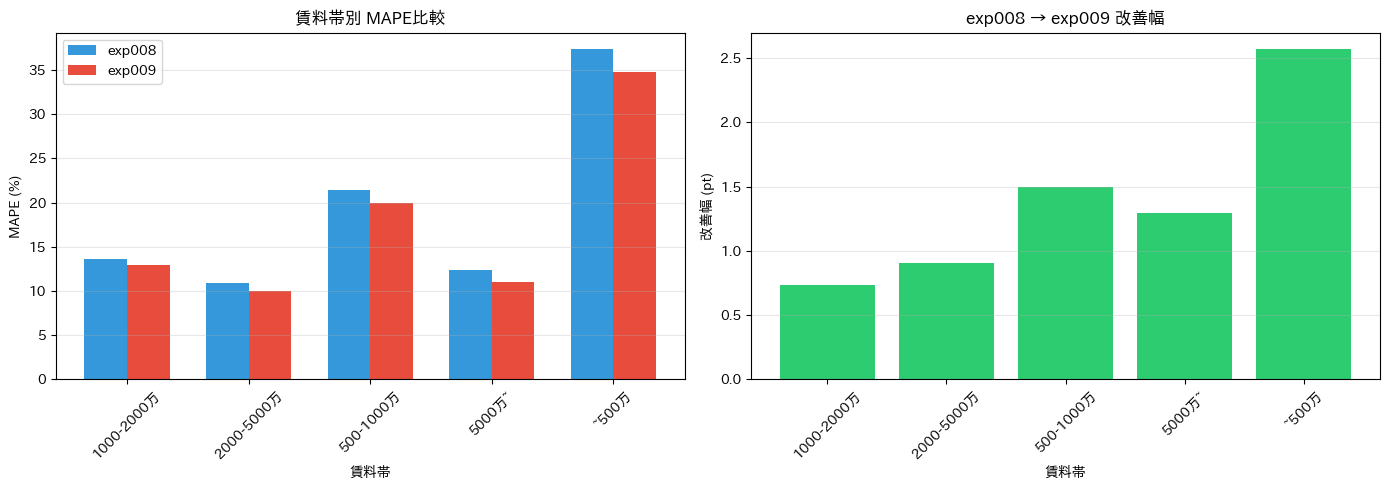

In [15]:
# exp008 vs exp009 可視化
if exp008_oof is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 賃料帯別MAPE比較
    ax = axes[0]
    x = np.arange(len(comparison))
    width = 0.35
    
    ax.bar(x - width/2, comparison["exp008"].to_numpy(), width, label='exp008', color='#3498DB')
    ax.bar(x + width/2, comparison["exp009"].to_numpy(), width, label='exp009', color='#E74C3C')
    
    ax.set_xticks(x)
    ax.set_xticklabels(comparison["price_bin"].to_list(), rotation=45)
    ax.set_xlabel("賃料帯")
    ax.set_ylabel("MAPE (%)")
    ax.set_title("賃料帯別 MAPE比較")
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 改善幅
    ax = axes[1]
    ax.bar(x, comparison["改善(pt)"].to_numpy(), color='#2ECC71')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison["price_bin"].to_list(), rotation=45)
    ax.set_xlabel("賃料帯")
    ax.set_ylabel("改善幅 (pt)")
    ax.set_title("exp008 → exp009 改善幅")
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / "exp008_vs_exp009.png", dpi=150, bbox_inches='tight')
    plt.show()

## 5. 実験結果サマリー

In [16]:
lp_importance_ratio = lp_features['importance'].sum() / importance_df['importance'].sum() * 100

print("=" * 60)
print("exp009 実験結果サマリー")
print("=" * 60)
print(f"\n【スコア】")
print(f"  CV MAPE: {oof_df['ape'].mean():.2f}%")
print(f"  ベースライン (exp008): 13.44%")
print(f"  改善: {13.44 - oof_df['ape'].mean():.2f}pt")
print(f"\n【特徴量】")
print(f"  総特徴量数: {len(importance_df)}")
print(f"  地価公示特徴量: {len(lp_features)}次元")
print(f"  地価公示特徴量の重要度割合: {lp_importance_ratio:.1f}%")
print(f"\n【モデル】")
print(f"  LightGBM (max_depth=10, num_leaves=127, min_child_samples=15)")
print(f"  learning_rate=0.05, n_estimators=50000")
print(f"\n【エラー分析】")
print(f"  MAPE: {oof_df['ape'].mean():.2f}%")
print(f"  中央値APE: {oof_df['ape'].median():.2f}%")
print(f"  MAE: {oof_df['error'].abs().mean():,.0f}円")
print("=" * 60)

exp009 実験結果サマリー

【スコア】
  CV MAPE: 12.48%
  ベースライン (exp008): 13.44%
  改善: 0.96pt

【特徴量】
  総特徴量数: 220
  地価公示特徴量: 39次元
  地価公示特徴量の重要度割合: 24.4%

【モデル】
  LightGBM (max_depth=10, num_leaves=127, min_child_samples=15)
  learning_rate=0.05, n_estimators=50000

【エラー分析】
  MAPE: 12.48%
  中央値APE: 8.32%


  MAE: 2,904,479円


## 6. 次回改善方針

In [17]:
print("""
============================================================
次回改善方針
============================================================

【高優先度】
1. 低価格帯(~500万)のエラー改善
   - 低価格物件向けの特徴量追加
   - サンプル数が少ない（2,573件）ため重み付け検討

2. 大エラーサンプルの分析
   - APE > 30%のサンプル（8.4%）の特徴分析
   - 外れ値/異常値の特定と処理

【中優先度】
3. 地価公示特徴量の拡張
   - 周辺地価の統計量（最小/最大/標準偏差）
   - 近隣地点数の追加

4. ハイパーパラメータチューニング
   - Optunaによる自動チューニング
   - 正則化パラメータの調整

【低優先度】
5. アンサンブル
   - CatBoost, XGBoostとのブレンド
   - スタッキング

6. 新規外部データ
   - 人口統計データ
   - 駅乗降客数データ
============================================================
""")


次回改善方針

【高優先度】
1. 低価格帯(~500万)のエラー改善
   - 低価格物件向けの特徴量追加
   - サンプル数が少ない（2,573件）ため重み付け検討

2. 大エラーサンプルの分析
   - APE > 30%のサンプル（8.4%）の特徴分析
   - 外れ値/異常値の特定と処理

【中優先度】
3. 地価公示特徴量の拡張
   - 周辺地価の統計量（最小/最大/標準偏差）
   - 近隣地点数の追加

4. ハイパーパラメータチューニング
   - Optunaによる自動チューニング
   - 正則化パラメータの調整

【低優先度】
5. アンサンブル
   - CatBoost, XGBoostとのブレンド
   - スタッキング

6. 新規外部データ
   - 人口統計データ
   - 駅乗降客数データ

